# A script for assigning boolean value to 'it is night time'

## Jason Kniss
### Feb 22 2024

Import libraries

In [1]:
# Import libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

Import data

In [2]:
# Test based on San Diego lat/long
lat = 32.715 # North(+)
long = 117.157 # West(+)

timedata = 'data/test/sd-spr-eq-dates.txt' # This will need to be kept updated to relative path
df = pd.read_csv(timedata, delimiter='\t')

In [3]:
df.head()

,JulianDay,HourMin
0,300,0
1,300,1
2,300,2
3,300,3
4,300,4


In [4]:
df.columns

Index(['JulianDay', 'HourMin'], dtype='object')

### 1) Determine declination

define sin/cos functions that expect degrees as the input

In [5]:
def cosd(degrees):
     return np.cos(np.deg2rad(degrees))
def sind(degrees):
    return np.sin(np.deg2rad(degrees))

In [6]:
df['B'] = (df['JulianDay'] - 1)*(360/365)
df['decl_1'] = (180/np.pi)*(0.006918 - 0.399912*cosd(df['B']) + 0.070257*sind(df['B']) - 0.006785*cosd(2*df['B']) + 0.000907*sind(2*df['B']) - 0.002697*cosd(3*df['B']) + 0.00148*sind(3*df['B']))
df['decl_2'] = 23.45*sind(360*(284 + df['JulianDay'])/365) # Less accurate but typically adequate for most engineering purposes

### 2) Determine hour angle

2a) determine local time in terms of minutes from *solar* noon (+ afternoon, - morning)

**Eureka data is logged as GMT/UTC time**

In [7]:
df['E'] = 229.2*(0.000075 + 0.001868*cosd(df['B']) - 0.032077*sind(df['B']) - 0.014615*cosd(2*df['B']) - 0.04089*sind(2*df['B']))

df['t_corr'] = 4*(0-long) + df['E']

In [8]:
def time_to_minutes(time_float):
    # Convert float to string and then to HHMM format
    time_str = str(int(time_float)).zfill(4)
    # Convert HHMM string to minutes
    hours = int(time_str[:2])
    minutes = int(time_str[2:])
    return hours * 60 + minutes

def minutes_from_noon(time_float):
    # Calculate the difference between the time and noon (720 minutes)
    time_minutes = time_to_minutes(time_float)
    minutes_difference = time_minutes - 720
    return minutes_difference

# Apply the minutes_from_noon function to the 'HourMin' column
df['MinutesFromNoon'] = df['HourMin'].apply(minutes_from_noon)

In [9]:
df['t_sol'] = df['MinutesFromNoon'] + df['t_corr']

In [10]:
def minutes_to_HourMin(minutes):
    # Calculate hours and minutes
    hours = int(minutes) // 60 + 12
    if hours < 0:
        hours += 24
    minutes = int(minutes) % 60

    # Format the time as HHMM
    return '{:02d}{:02d}'.format(hours, minutes)

df['local_time'] = df['t_sol'].apply(minutes_to_HourMin)

In [11]:
def GMT_to_std(time_float):
    if time_float >= 100*((long // 15)+1):
        time_diff = -100*((long // 15)+1)
    else:
        time_diff = 2400 - 100*((long // 15)+1)

    return time_float + time_diff
        
df['std_time'] = df['HourMin'].apply(GMT_to_std) # convert GMT to local standard time

In [12]:
df['w'] = df['t_sol'] * (360/1440)

In [13]:
df['theta_z'] =  np.degrees(np.arccos(cosd(lat) * cosd(df['decl_1']) * cosd(df['w']) + sind(lat) * sind(df['decl_1'])))

In [14]:
print(min(df['theta_z']))
print(max(df['theta_z']))

45.2360687224512
160.81698932294165


In [15]:
df['isnight'] = (df['theta_z'] > 105) | (df['theta_z'] < -105)

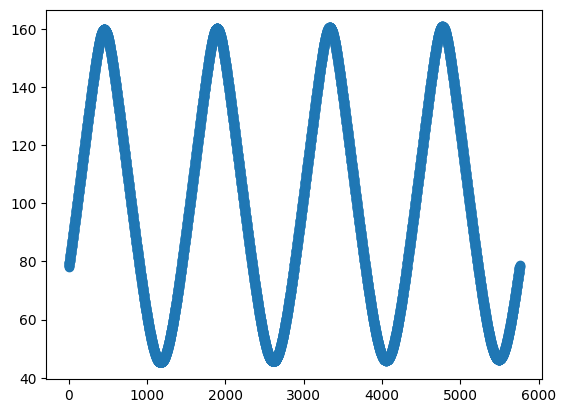

In [17]:
plt.scatter(df.index, df['theta_z'])

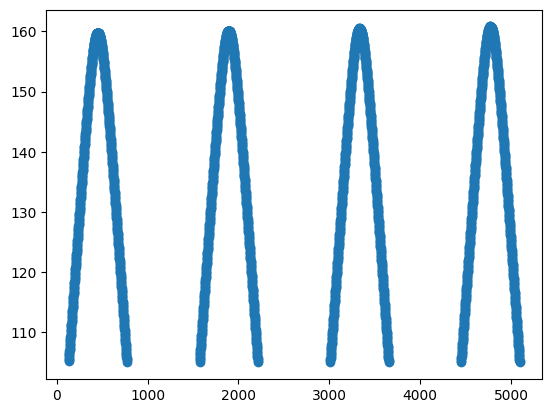

In [18]:
plt.scatter(df.index[df['isnight']==True], df['theta_z'][df['isnight']==True])

In [19]:
file_path = 'data/test/printed-file.xlsx'
df.to_excel(file_path, index=False)